<a href="https://colab.research.google.com/github/ivyevaa/mlpc-project/blob/main/mlpcindv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import os

In [ ]:
# GPU Libraries
!pip install xgboost --upgrade
import xgboost as xgb

In [ ]:
# This cell is no longer needed as the data was loaded in a previous cell.

In [ ]:
# Load dataset
#file_name = list(uploaded.keys())[0] # This line is no longer needed as the data is loaded differently
df = pd.read_csv('/content/query (1).csv') # This line is no longer needed as the data is loaded differently
df.shape

(17016, 22)

In [ ]:
# Data Cleaning
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['updated'] = pd.to_datetime(df['updated'], errors='coerce')
df.drop_duplicates(inplace=True)

# Drop columns with too many nulls
threshold = 0.4
df = df[df.columns[df.isnull().mean() < threshold]]

# Fill missing numerical with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill object columns with mode
obj_cols = df.select_dtypes(include='object').columns
for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# New time features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

In [ ]:
# EDA
print("\n--- Dataset Overview ---")
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

print("\nTop Locations:\n", df['place'].value_counts().head())
print("\nMagnitude Types:\n", df['magType'].value_counts())
print("\nEvent Types:\n", df['type'].value_counts())

print("\n--- Descriptive Statistics ---")
print(df.describe())



--- Dataset Overview ---
Shape: (17016, 25)

Data Types:
 time               datetime64[ns, UTC]
latitude                       float64
longitude                      float64
depth                          float64
mag                            float64
magType                         object
nst                            float64
gap                            float64
dmin                           float64
rms                            float64
net                             object
id                              object
updated            datetime64[ns, UTC]
place                           object
type                            object
horizontalError                float64
depthError                     float64
magError                       float64
magNst                         float64
status                          object
locationSource                  object
magSource                       object
year                             int32
month                            int32
day  

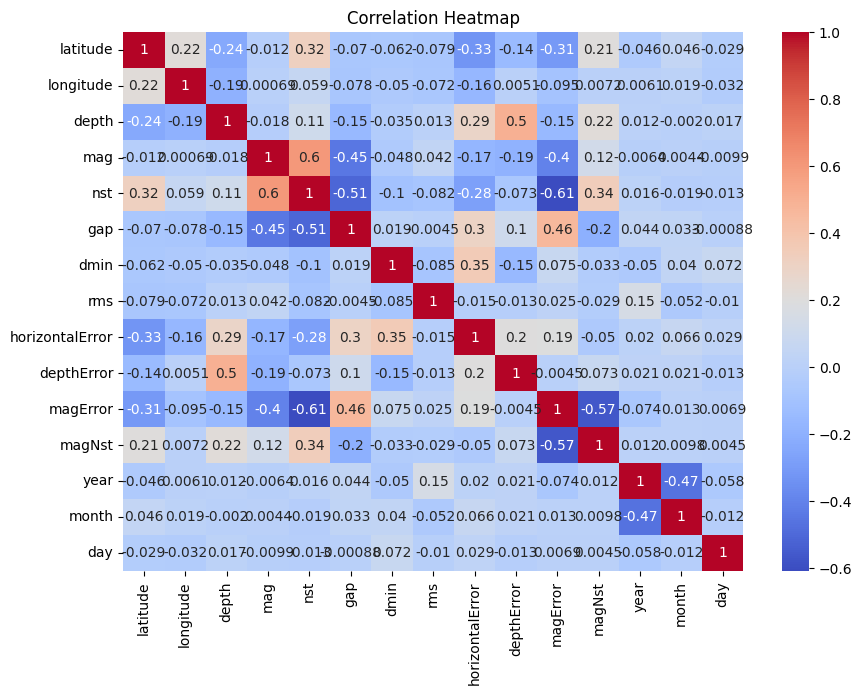

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

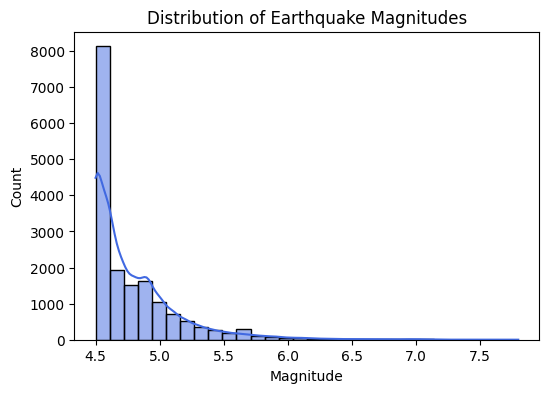

In [ ]:
# Magnitude histogram
plt.figure(figsize=(6, 4))
sns.histplot(df['mag'], bins=30, kde=True, color='royalblue')
plt.title("Distribution of Earthquake Magnitudes")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.show()

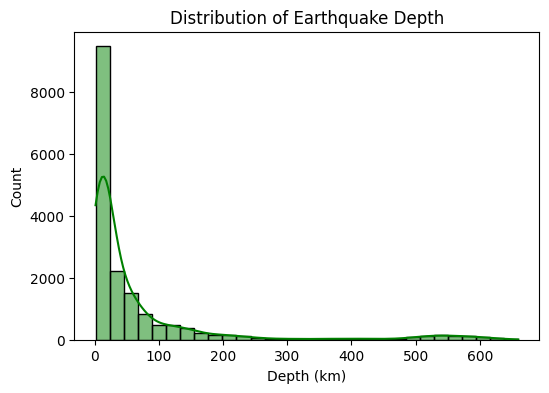

In [ ]:
# Depth histogram
plt.figure(figsize=(6, 4))
sns.histplot(df['depth'], bins=30, kde=True, color='green')
plt.title("Distribution of Earthquake Depth")
plt.xlabel("Depth (km)")
plt.ylabel("Count")
plt.show()

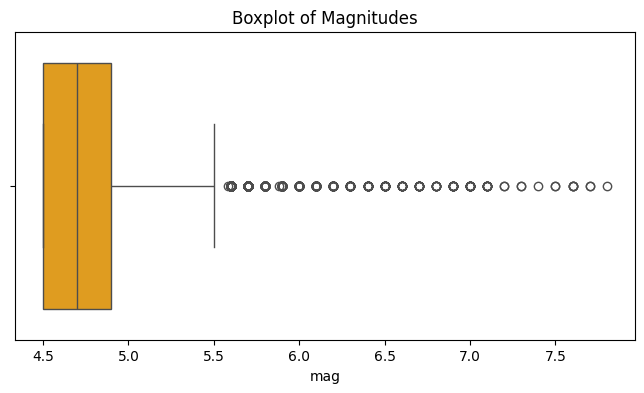

In [ ]:
# Boxplots
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['mag'], color='orange')
plt.title("Boxplot of Magnitudes")
plt.show()


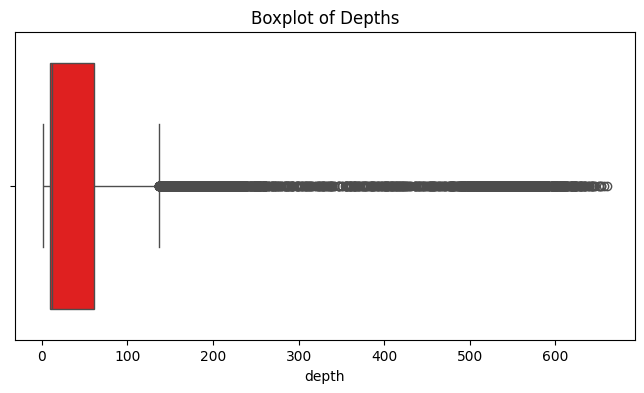

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['depth'], color='red')
plt.title("Boxplot of Depths")
plt.show()

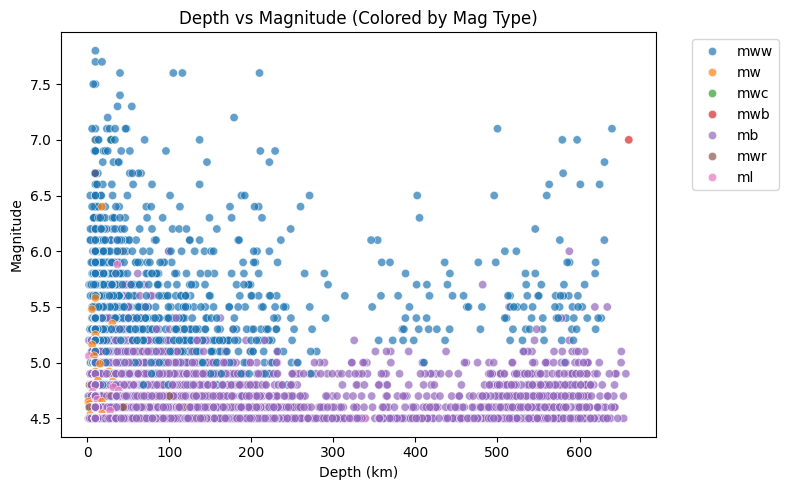

In [ ]:
# Scatterplot depth vs magnitude
plt.figure(figsize=(8, 5))
sns.scatterplot(x='depth', y='mag', data=df, hue='magType', alpha=0.7)
plt.title("Depth vs Magnitude (Colored by Mag Type)")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

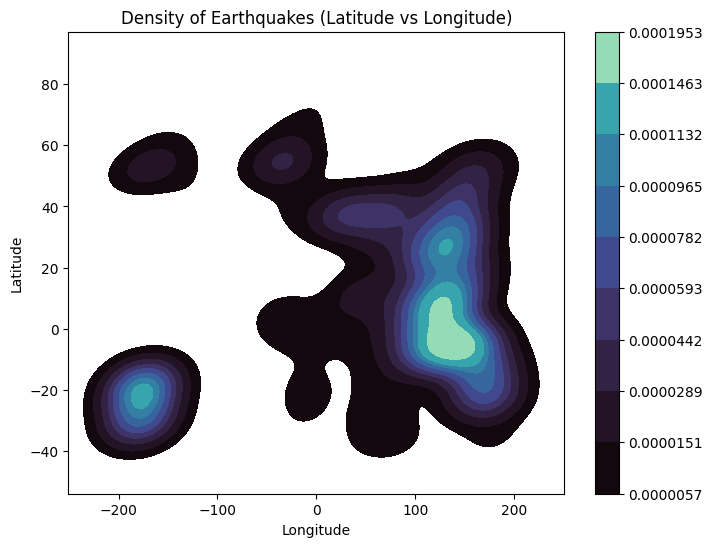

In [ ]:
# KDE location heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df['longitude'], y=df['latitude'], cmap="mako", fill=True, cbar=True)
plt.title("Density of Earthquakes (Latitude vs Longitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

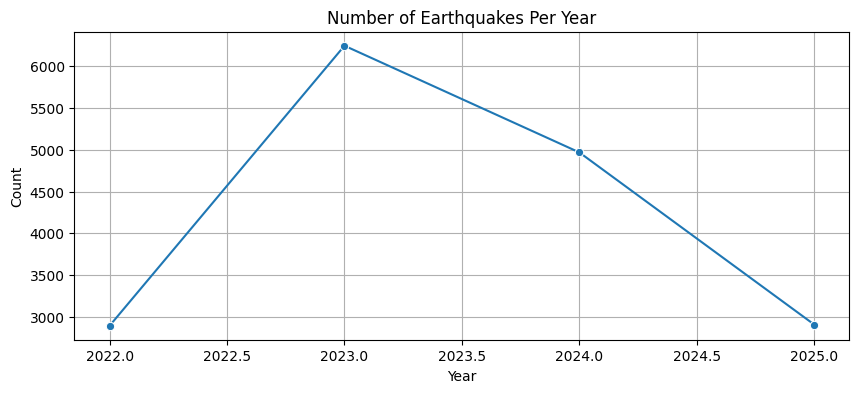

In [ ]:
# Earthquakes per year
yearly = df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
sns.lineplot(x=yearly.index, y=yearly.values, marker='o')
plt.title("Number of Earthquakes Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

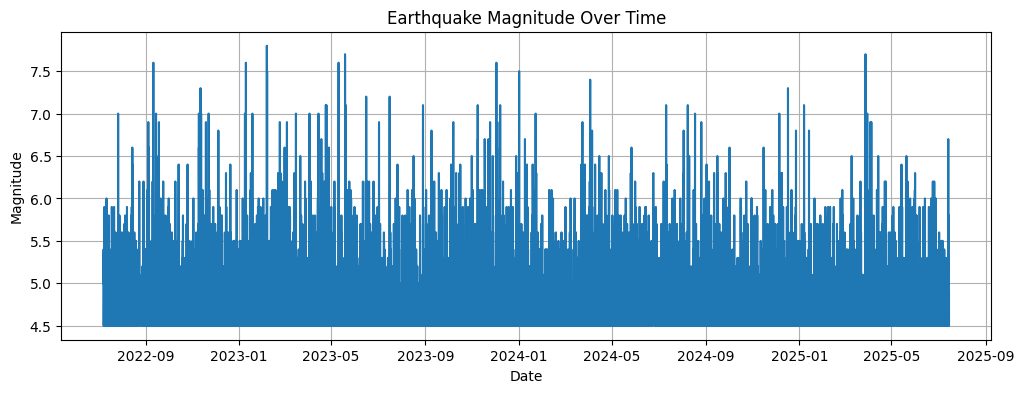

In [ ]:
# Magnitude over time
plt.figure(figsize=(12, 4))
sns.lineplot(x='time', y='mag', data=df)
plt.title("Earthquake Magnitude Over Time")
plt.xlabel("Date")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()


In [ ]:
#Train/Test Split
features = ['latitude', 'longitude', 'depth', 'gap', 'rms',
            'horizontalError', 'depthError', 'magError', 'magNst',
            'year', 'month', 'day']

X = df[features]
y = df['mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Random Forest (CPU)
start = time.time()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_train_time = time.time() - start

rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_accuracy = np.mean(np.abs(rf_pred - y_test) <= 0.2)

print("\n--- Random Forest (CPU) ---")
print(f"Training Time: {rf_train_time:.4f}s")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R² Score: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"Custom Accuracy (±0.2): {rf_accuracy*100:.2f}%")



--- Random Forest (CPU) ---
Training Time: 7.0038s
RMSE: 0.1887
R² Score: 0.7307
MAE: 0.1250
Custom Accuracy (±0.2): 82.49%


In [ ]:
# XGBoost (GPU)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'tree_method': 'hist', # Changed from 'gpu_hist'
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

start = time.time()
xgb_model = xgb.train(params, dtrain, num_boost_round=100)
gpu_train_time = time.time() - start

xgb_pred = xgb_model.predict(dtest)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_accuracy = np.mean(np.abs(xgb_pred - y_test) <= 0.2)

print("\n--- XGBoost (GPU) ---")
print(f"Training Time: {gpu_train_time:.4f}s")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"R² Score: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"Custom Accuracy (±0.2): {xgb_accuracy*100:.2f}%")


--- XGBoost (GPU) ---
Training Time: 1.0525s
RMSE: 0.1843
R² Score: 0.7431
MAE: 0.1238
Custom Accuracy (±0.2): 82.34%



--- Model Performance Comparison ---
Model                          Accuracy (±0.2)         Training Time (s)
----------------------------------------------------------------------
Random Forest (CPU)                   82.49%                    7.0038
XGBoost (GPU)                         82.34%                    1.0525


/tmp/ipython-input-26-3560464367.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='crest')
/tmp/ipython-input-26-3560464367.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=times, palette='flare')


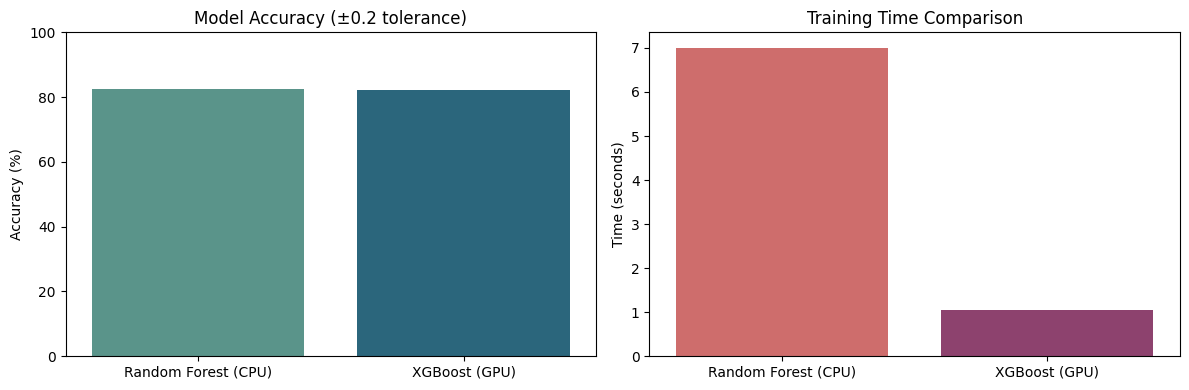

In [ ]:
# Comparison
print("\n--- Model Performance Comparison ---")
print(f"{'Model':<25} {'Accuracy (±0.2)':>20} {'Training Time (s)':>25}")
print(f"{'-'*70}")
print(f"{'Random Forest (CPU)':<25} {rf_accuracy*100:>17.2f}% {rf_train_time:>25.4f}")
print(f"{'XGBoost (GPU)':<25} {xgb_accuracy*100:>17.2f}% {gpu_train_time:>25.4f}")

#Optional Visualization
import seaborn as sns
models = ['Random Forest (CPU)', 'XGBoost (GPU)']
accuracies = [rf_accuracy * 100, xgb_accuracy * 100]
times = [rf_train_time, gpu_train_time]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=accuracies, palette='crest')
plt.title("Model Accuracy (±0.2 tolerance)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=times, palette='flare')
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()
